In [1]:
# Import required packages
from os import path 
import time
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from torch import nn, Tensor
from torch.optim import AdamW
from tqdm import tqdm, trange
import zuko
from zuko.flows import Distribution, NSF
from zuko.distributions import DiagNormal, BoxUniform, Minimum
from zuko.flows import DistributionModule, FlowModule, Unconditional
from hnne import HNNE

from utils.settings import config
from utils.utils import *
from utils.model import *
from utils.robot import Robot
from utils.dataset import create_dataset

In [2]:
panda = Robot(verbose=False)
# data generation
X, y = load_data(robot=panda)
# build dimension reduction model
hnne, ds, loader = get_hnne_model(X, y)
# Build Generative model, NSF
# Neural spline flow (NSF) with 3 sample features and 5 context features
flow, optimizer, scheduler = get_flow_model()

hnne load successfully from ./weights/hnne.pickle
Finding nearest centroids to new data...
Setting up once a knn index for the last level centroids...
Tue May 23 18:28:25 2023 Building RP forest with 32 trees
Tue May 23 18:28:29 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Tue May 23 18:30:22 2023 Worst tree score: 0.94792173
Tue May 23 18:30:22 2023 Mean tree score: 0.94840575
Tue May 23 18:30:22 2023 Best tree score: 0.94966836
Tue May 23 18:30:25 2023 Forward diversification reduced edges from 20009880 to 6167096
Tue May 23 18:30:28 2023 Reverse diversification reduced edges from 6167096 to 6167096
Tue May 23 18:30:30 2023 Degree pruning reduced edges from 6697886 to 6697886
Tue May 23 18:30:30 2023 Resorting data and graph based on tree order
Tue May 23 18:30:30 2023 Building and compiling search function
Projecting data...
Model load successfully from ./weights/nsf.pth


,l2_err,log_prob
count,2400.000000,2400.000000
mean,0.006535,-9.183444
std,0.009226,2.198816
min,0.000304,-14.368955
25%,0.002986,-10.722239
50%,0.004806,-9.447618
75%,0.007241,-7.955671
max,0.157211,1.850196


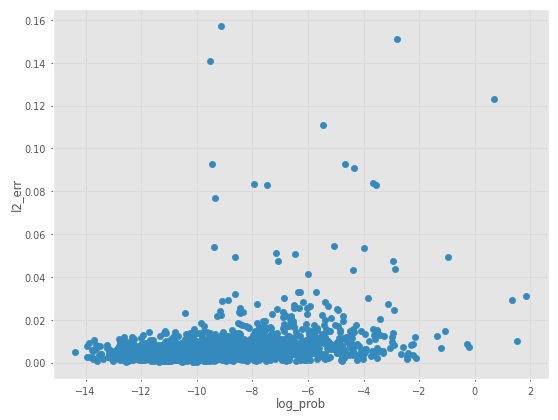

In [3]:
df, err = test_l2_err(config, robot=panda, loader=loader, model=flow)
ax1 = df.plot.scatter(x='log_prob', y='l2_err')
df.describe()

,l2_err,log_prob
count,2400.000000,2400.000000
mean,0.005578,-13.771702
std,0.009360,1.404367
min,0.000204,-17.725368
25%,0.002723,-14.699298
50%,0.004236,-14.074979
75%,0.006308,-12.969445
max,0.266781,-6.656440


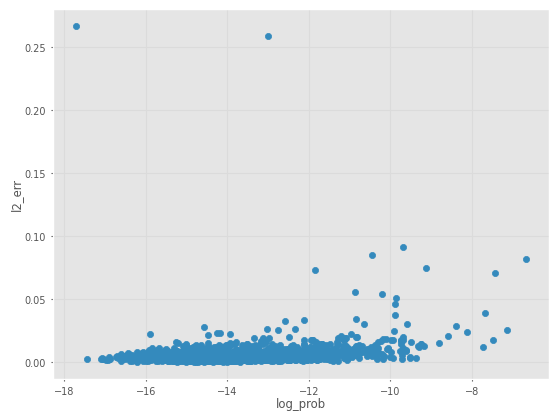

In [4]:
nflow = get_nflow_model(flow=flow)
df, err = test_l2_err(config, robot=panda, loader=loader, model=nflow)
ax1 = df.plot.scatter(x='log_prob', y='l2_err')
df.describe()

In [5]:
sample_traj(hnne, model=nflow, robot=panda, num_traj=3)

100%|██████████| 20/20 [00:00<00:00, 12501.65it/s]


mkdir ./data/trajectory/05231831
[[ 0.218868   -0.4819177   0.80006504 -0.05264571]
 [ 0.218868   -0.4819177   0.80006504 -0.05264571]
 [ 0.2188682  -0.48191514  0.8000678  -0.05264675]]
          l2_err   log_prob
count  20.000000  20.000000
mean    0.003474 -14.557306
std     0.002009   0.478737
min     0.001740 -15.489088
25%     0.002437 -14.785043
50%     0.002919 -14.662383
75%     0.003524 -14.333390
max     0.009491 -13.613035
          l2_err   log_prob
count  20.000000  20.000000
mean    0.004038 -14.507372
std     0.002413   0.525141
min     0.000325 -15.741920
25%     0.002474 -14.731403
50%     0.003500 -14.517317
75%     0.005539 -14.299921
max     0.009440 -13.341654
          l2_err   log_prob
count  20.000000  20.000000
mean    0.003569 -14.637557
std     0.001805   0.567232
min     0.001740 -15.714819
25%     0.002317 -14.944946
50%     0.002767 -14.589903
75%     0.004250 -14.402074
max     0.008431 -13.613806
(array([], dtype=int64),)
[]
0.06948801861085258
(array([

In [ ]:
generate_new = True
 
traj_dir = config.traj_dir + datetime.now().strftime('%m%d%H%M') + '/'
ee_traj_path = traj_dir + 'ee_traj.npy'
q_traj_path = traj_dir + 'q_traj.npy'

if not generate_new and path.exists(path=q_traj_path):
    ee_traj = load_numpy(file_path=ee_traj_path)
    q_traj = load_numpy(file_path=q_traj_path)
else:
    ee_traj, q_traj = panda.path_generate_via_stable_joint_traj(dist_ratio=0.9, t=20)
    save_numpy(file_path=ee_traj_path, arr=ee_traj)
    save_numpy(file_path=q_traj_path, arr=q_traj)

In [ ]:
num_traj = 3
rand = np.random.randint(low=0, high=len(q_traj), size=num_traj)
pidx = hnne.transform(X=q_traj[rand])
pidx

In [ ]:
for i, px in enumerate(pidx):
    df, qs = sample_jtraj(ee_traj, px, nflow)
    print(df.describe())
    save_numpy(file_path=traj_dir + f'/exp_{i}.npy', arr=qs)

In [ ]:
ee_traj = load_numpy(file_path=ee_traj_path)
err = np.zeros((100,))

for i in range(3):
    step = 0
    qs = load_numpy(file_path=traj_dir + f'/exp_{i}.npy')
    for i in range(len(qs)):
        err[i] = panda.dist_fk(q=qs[i], ee_pos=ee_traj[i])
    outliner = np.where(err > 0.05)
    print(outliner)
    print(err[outliner])
    print(np.sum(err))
    panda.plot_qs(qs)